In [89]:
from pathlib import Path
import json

from adjustText import adjust_text
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from cblearn.metrics import query_error
from matplotlib.ticker import ScalarFormatter
import datasets


sns.set_theme("paper", "whitegrid", font_scale=1.5)
plot_dir = Path('../plots')
plot_dir.mkdir(exist_ok=True)

## Plot datasets

In [90]:
data = datasets.fetch_all(download_if_missing=True)
data = pd.DataFrame.from_records(data).transpose()
data['n_triplets'] = data.train_triplets.map(len)
data

,train_triplets,n_objects,n_triplets
car,"[[52, 7, 22], [18, 53, 52], [14, 17, 52], [22,...",60,14194
food,"[[88, 13, 15], [91, 79, 75], [92, 57, 44], [88...",100,190376
imagenet-v1,"[[672, 393, 418], [672, 393, 687], [672, 393, ...",1000,328549
imagenet-v2,"[[47769, 989, 47732], [47769, 989, 45615], [47...",50000,4995600
material,"[[32, 78, 22], [70, 6, 9], [67, 50, 33], [48, ...",100,92892
musician,"[[5, 305, 391], [31, 98, 234], [167, 107, 82],...",448,118263
nature,"[[93, 70, 62], [8, 64, 28], [58, 111, 78], [11...",120,6710
things,"[[1352, 960, 628], [81, 1668, 594], [502, 1463...",1854,292024
vogue,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214


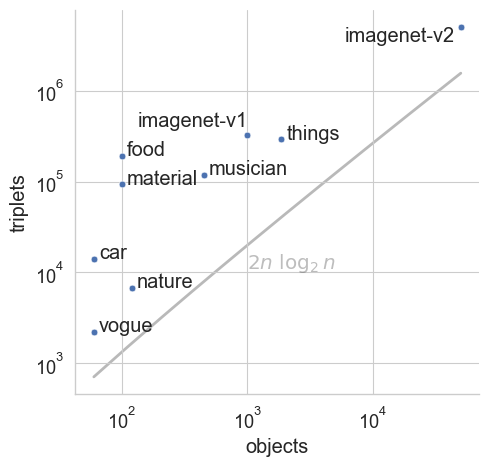

In [91]:
names = data.index
fg = sns.relplot(data, y='n_triplets', x='n_objects', legend=None)
fg.set(xlabel='objects', ylabel='triplets', xscale='log', yscale='log')

obj_space = np.linspace(np.min(data.n_objects), np.max(data.n_objects), 1000)
triplet_space = 2 * obj_space * np.log2(obj_space)
plt.plot(obj_space, triplet_space, 'k-', alpha=0.3, lw=2, zorder=-1)

plt.text(10e2, 1.1*10e3, f"$2n~\log_2 n$", alpha=0.3, horizontalalignment='left')
labels = {name: plt.text(x*1.1, y, name) for name, y, x in zip(names, data.n_triplets, data.n_objects)}
labels['imagenet-v1'].set_y(4*10e4)
labels['imagenet-v1'].set_horizontalalignment('right')
labels['imagenet-v1'].set_x(10e2)
labels['imagenet-v2'].set_horizontalalignment('right')
labels['imagenet-v2'].set_verticalalignment('top')
labels['imagenet-v2'].set_x(4.5*10e3)
#labels['things'].set_y(2*10e4)
#adjust_text(labels,expand_points=(2, 2))

fg.savefig(plot_dir / 'datasets.pdf')
fg.savefig(plot_dir / 'datasets.png')
plt.show()

## Load results

In [92]:
results = []
for r in Path('../results/').glob('*.json'):
    try:
        with r.open('r') as f:
            d = json.load(f)
            if isinstance(d, list) and len(d) == 1:
                d = d[0]

        if np.any(np.isnan(d['embedding'])):
            print(f"skip {r} because embedding contains NaNs.")
            continue
        try:
            d['error'] = query_error(data.loc[d['dataset'], 'train_triplets'], np.array(d['embedding']))
        except ValueError as e:
            print(d['dataset'])
            raise e
        del d['embedding']
        if d['library'] == 'cblearn':
            d['name'] = f"{d['algorithm']} (ours)"
        elif d['library'] == 'loe':
            d['name'] = f"{d['algorithm']} (loe)"
        elif d['library'] == 'vanderMaaten':
            d['name'] = f"{d['algorithm']} (STE)"
        else:
            d['name'] = f"{d['algorithm']}"
    except:
        print(f"Error loading {r}")
        raise  # re-raise exception

    results.append(d)

results = pd.DataFrame.from_records(results)
results = results.join(data, on='dataset')


In [93]:
results['is_gpu'] = results.algorithm.str.endswith('-GPU')
results['algorithm'] = results.algorithm.str.replace('-GPU', '')
results['proc'] = results.is_gpu.map({True: 'GPU', False: 'CPU'})
results

,dataset,library,algorithm,loss,cpu_time,error,name,_row,train_triplets,n_objects,n_triplets,is_gpu,proc
0,vogue,cblearn,STE,4.656913e-01,9.452453,0.216802,STE-GPU (ours),NaN,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214,True,GPU
1,food,cblearn,CKL,7.800696e+04,4.161895,0.187492,CKL (ours),NaN,"[[88, 13, 15], [91, 79, 75], [92, 57, 44], [88...",100,190376,False,CPU
2,vogue,cblearn,GNMDS,1.142312e+03,0.700857,0.220867,GNMDS (ours),NaN,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214,False,CPU
3,food,cblearn,CKL,4.313153e-01,3302.594706,0.204353,CKL-GPU (ours),NaN,"[[88, 13, 15], [91, 79, 75], [92, 57, 44], [88...",100,190376,True,GPU
4,musician,cblearn,SOE,7.211700e-03,37.297788,0.268655,SOE (ours),NaN,"[[5, 305, 391], [31, 98, 234], [167, 107, 82],...",448,118263,False,CPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,vogue,vanderMaaten,GNMDS,NaN,0.310000,0.222222,GNMDS (STE),NaN,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214,False,CPU
136,material,cblearn,GNMDS,9.866634e-01,1647.268070,0.228954,GNMDS-GPU (ours),NaN,"[[32, 78, 22], [70, 6, 9], [67, 50, 33], [48, ...",100,92892,True,GPU
137,imagenet-v2,cblearn,tSTE,3.252099e+06,7687.849653,0.314256,tSTE (ours),NaN,"[[47769, 989, 47732], [47769, 989, 45615], [47...",50000,4995600,False,CPU
138,things,cblearn,FORTE,6.964798e-01,89.402684,0.446477,FORTE-GPU (ours),NaN,"[[1352, 960, 628], [81, 1668, 594], [502, 1463...",1854,292024,True,GPU


## Plot results

In [94]:

results.query('library == "cblearn" and not is_gpu').sort_values(by='n_objects')

,dataset,library,algorithm,loss,cpu_time,error,name,_row,train_triplets,n_objects,n_triplets,is_gpu,proc
99,car,cblearn,CKL,6.686090e+03,0.360198,0.193814,CKL (ours),NaN,"[[52, 7, 22], [18, 53, 52], [14, 17, 52], [22,...",60,14194,False,CPU
60,vogue,cblearn,CKL,9.753328e+02,0.281958,0.210479,CKL (ours),NaN,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214,False,CPU
44,car,cblearn,GNMDS,7.299660e+03,0.144503,0.189376,GNMDS (ours),NaN,"[[52, 7, 22], [18, 53, 52], [14, 17, 52], [22,...",60,14194,False,CPU
67,vogue,cblearn,STE,3.599482e+03,0.158687,0.301716,STE (ours),NaN,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214,False,CPU
102,car,cblearn,SOE,6.082625e-03,0.413740,0.192687,SOE (ours),NaN,"[[52, 7, 22], [18, 53, 52], [14, 17, 52], [22,...",60,14194,False,CPU
11,vogue,cblearn,SOE,6.163821e-03,0.104343,0.214544,SOE (ours),NaN,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214,False,CPU
127,car,cblearn,tSTE,7.358987e+03,0.377483,0.203184,tSTE (ours),NaN,"[[52, 7, 22], [18, 53, 52], [14, 17, 52], [22,...",60,14194,False,CPU
7,car,cblearn,STE,2.957576e+04,0.349000,0.369875,STE (ours),NaN,"[[52, 7, 22], [18, 53, 52], [14, 17, 52], [22,...",60,14194,False,CPU
122,vogue,cblearn,tSTE,1.255460e+03,0.059432,0.250226,tSTE (ours),NaN,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214,False,CPU
2,vogue,cblearn,GNMDS,1.142312e+03,0.700857,0.220867,GNMDS (ours),NaN,"[[24, 35, 44], [31, 17, 29], [21, 38, 22], [13...",60,2214,False,CPU


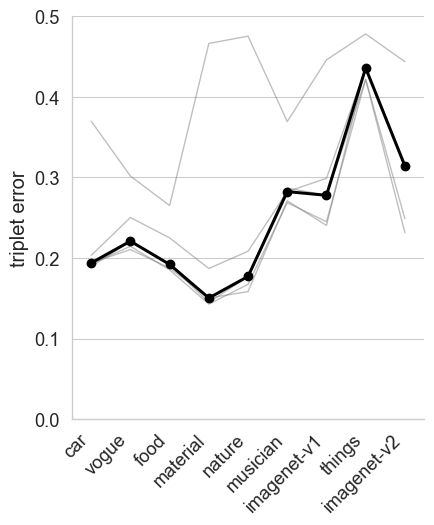

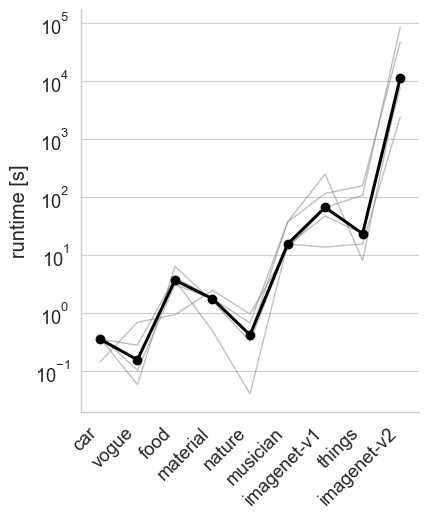

In [95]:
this_data = results.query('library == "cblearn" and not is_gpu').sort_values(by='n_objects')
fg = sns.relplot(data=this_data,
                 x="dataset", y="error", kind="line", estimator=None, units="algorithm",
                 color='grey', alpha=0.5, lw=1)
sns.pointplot(data=this_data, x='dataset', y='error', estimator=np.median,
              errorbar=None, color='black')
plt.xticks(rotation=45, horizontalalignment='right')
fg.set(ylabel='triplet error', xlabel='', ylim=(0, 0.5))
fg.savefig(plot_dir / f'error-per-dataset_cblearn.pdf')
fg.savefig(plot_dir / f'error-per-dataset_cblearn.png')


fg = sns.relplot(data=this_data,
                 x="dataset", y="cpu_time", kind="line", estimator=None, units="algorithm",
                 color='grey', alpha=0.5, lw=1)
sns.pointplot(data=this_data, x='dataset', y='cpu_time', estimator=np.median,
              errorbar=None, color='black')
plt.xticks(rotation=45, horizontalalignment='right')
fg.set(ylabel='runtime [s]', xlabel='', yscale='log')
fg.savefig(plot_dir / f'time-per-dataset_cblearn.pdf')
fg.savefig(plot_dir / f'time-per-dataset_cblearn.png')

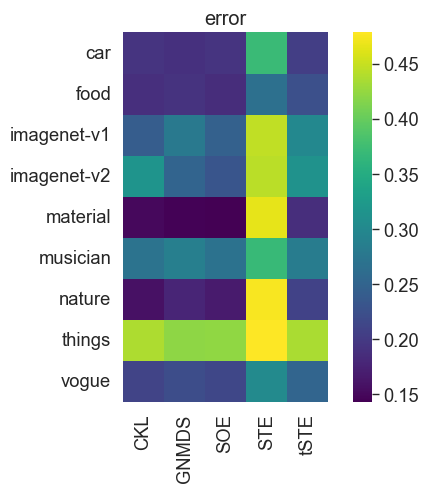

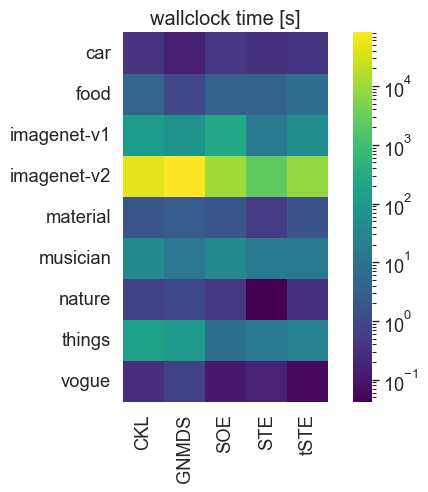

In [96]:
# long form to wide form to plot heatmap of errors
df = results.query('library == "cblearn" and not is_gpu').sort_values(by='n_objects')

sq_df = df.pivot(index='dataset', columns='algorithm', values='error')
ax = sns.heatmap(sq_df, annot=False, fmt='.2e', cmap='viridis', square=True)
ax.set(xlabel="", ylabel="", title='error')
plt.savefig(plot_dir / f'error-per-dataset-algorithm_cblearn.pdf')
plt.savefig(plot_dir / f'error-per-dataset-algorithm_cblearn.png')
plt.show()

sq_df = df.pivot(index='dataset', columns='algorithm', values='cpu_time')
ax = sns.heatmap(sq_df, annot=False, fmt='.2e', cmap='viridis', square=True, norm=LogNorm())
ax.set(xlabel="", ylabel="", title='wallclock time [s]')

plt.savefig(plot_dir / f'time-per-dataset-algorithm_cblearn.pdf')
plt.savefig(plot_dir / f'time-per-dataset-algorithm_cblearn.png')

algorithm  proc
CKL        CPU      4895.001880
           GPU     33384.247435
FORTE      GPU        20.403867
GNMDS      CPU      6515.460574
           GPU     10373.987810
SOE        CPU       737.476758
           GPU      5006.726343
STE        CPU       181.164111
           GPU      5868.964573
tSTE       CPU     19156.142376
           GPU      5316.754511
Name: cpu_time, dtype: float64


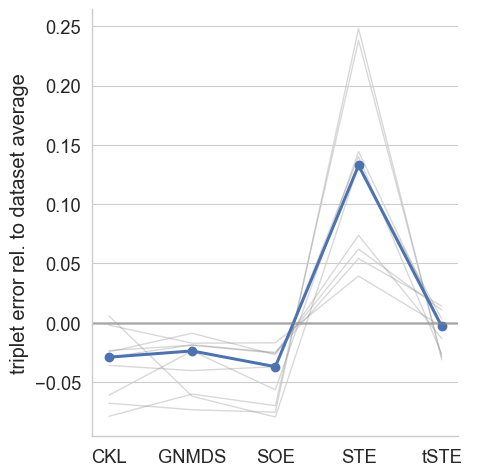

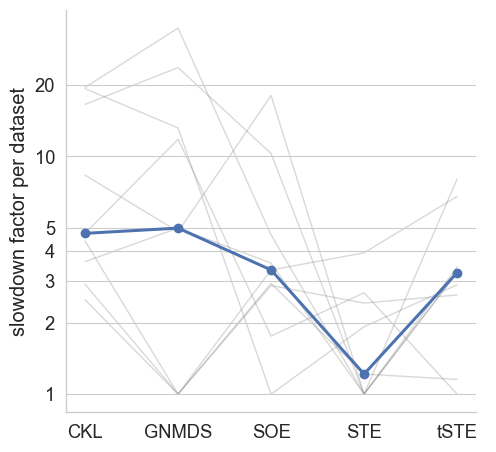

In [97]:
def plot_error_improvement(df, y='error', groupby='dataset', kind='point', orient='v', **kwargs):
    x = 'algorithm'
    df = df.sort_values(by=[x])
    raw_y = y
    y = f'rel_{raw_y}'
    if orient == 'h':
        x, y = y, x
    mean = df.groupby(groupby)[raw_y].transform('mean')
    df[f'rel_{raw_y}'] = (df[raw_y] - mean)
    #df[f'rel_{raw_y}'] = df[f'rel_{raw_y}'] - df[f'rel_{raw_y}'].min()
    fg = sns.catplot(data=df, x=x, y=y, kind=kind, estimator=np.median, errorbar=None, **kwargs)
    if kind == 'point':
        this_kwargs = kwargs.copy()
        if 'color' in this_kwargs:
            del this_kwargs['color']
        if 'legend' in this_kwargs:
            del this_kwargs['legend']
        sns.lineplot(data=df, x=x, y=y, estimator=None, units=groupby,
                     alpha=0.3, lw=1, color='grey', zorder=0, **this_kwargs)
    txt = f'triplet error rel. to dataset average'
    if orient == 'h':
        fg.set(xlabel=txt, ylabel='')
        fg.map(plt.axvline, x=0, color='grey', alpha=0.5, lw=2)
    else:
        fg.set(ylabel=txt, xlabel='')
        fg.map(plt.axhline, y=0, color='grey', alpha=0.5, lw=2)
    return fg

def plot_time_improvement(df, y='cpu_time', groupby='dataset', kind='point', orient='v', **kwargs):
    x = 'algorithm'
    df = df.sort_values(by=[x])
    raw_y = y
    y = f'rel_{raw_y}'
    if orient == 'h':
        x, y = y, x
    #mean = df.groupby(groupby)[raw_y].transform('mean')
    min_df = df.groupby(groupby)[raw_y].transform('min')
    #df[f'rel_{raw_y}'] = (df[raw_y] - min_df) / (mean - min_df) * 100
    df[f'rel_{raw_y}'] = df[raw_y] / min_df

    #df[f'rel_{raw_y}'] = df[f'rel_{raw_y}'] - df[f'rel_{raw_y}'].min()
    fg = sns.catplot(data=df, x=x, y=y, kind=kind,
                     estimator=np.median, errorbar=None, **kwargs)
    if kind == 'point':
        this_kwargs = kwargs.copy()
        if 'color' in this_kwargs:
            del this_kwargs['color']
        if 'legend' in this_kwargs:
            del this_kwargs['legend']
        sns.lineplot(data=df, x=x, y=y, estimator=None, units=groupby,
                     alpha=0.3, lw=1, color='grey', zorder=0, legend=False, **this_kwargs)
    txt = f'slowdown factor per dataset'

    if orient == 'h':
        fg.set(xlabel=txt, ylabel='')
        #fg.map(plt.axvline, x=0, color='grey', alpha=0.5, lw=2)
    else:
        fg.set(yscale='log')
        fg.ax.yaxis.set_major_formatter(ScalarFormatter())
        fg.set(ylabel=txt, xlabel='')
        #fg.map(plt.axhline, y=0, color='grey', alpha=0.5, lw=2)
    return fg


df = results.query('library == "cblearn" and not is_gpu').copy(deep=True)
print(results.groupby(['algorithm', 'proc'])['cpu_time'].mean())
fg = plot_error_improvement(df, color='C0')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn.png')

fg = plot_time_improvement(df, y='cpu_time', color='C0')
fg.set(yscale='log', yticks=[1, 2, 3, 4, 5, 10, 20])
fg.ax.yaxis.set_major_formatter(ScalarFormatter())
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn.png')

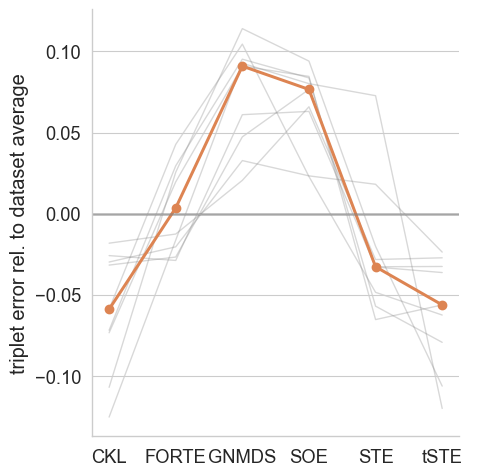

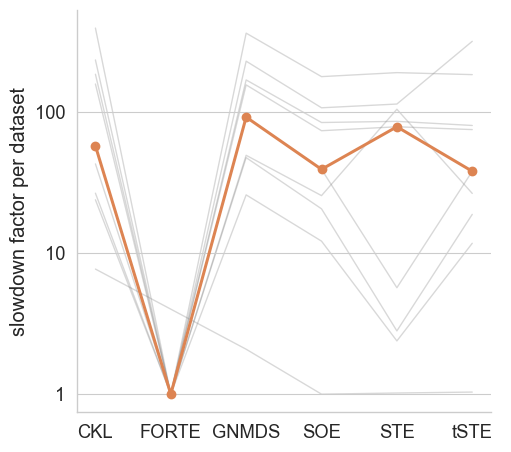

In [98]:
df = results.query('library == "cblearn" and is_gpu').copy(deep=True)
fg = plot_error_improvement(df, color='C1')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn-gpu.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn-gpu.png')

fg = plot_time_improvement(df, y='cpu_time', color='C1')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn-gpu.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn-gpu.png')

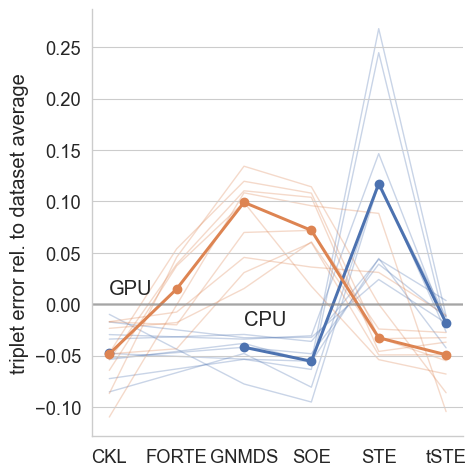

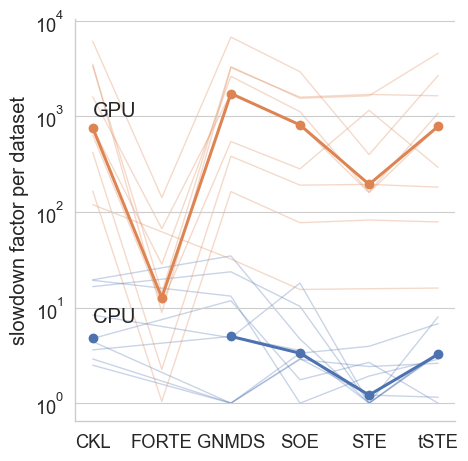

In [99]:
df = results.query('library == "cblearn"').copy(deep=True)
fg = plot_error_improvement(df, hue='proc', hue_order=['CPU', 'GPU'], orient='v', legend=False)
fg.set_titles('GPU = {col_name}')
plt.text(0, 0.01, 'GPU')
plt.text(2, -0.02, 'CPU')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn-all.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn-all.png')

fg = plot_time_improvement(df, hue='proc', hue_order=['CPU', 'GPU'], legend=False)

plt.text(0, 1000, 'GPU')
plt.text(0, 7, 'CPU')
#fg.legend.set_title('')
fg.set(yscale='log')
#sns.move_legend(fg, 'upper left', frameon=True, bbox_to_anchor=(0.3, 0.8))
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn-all.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn-all.png')

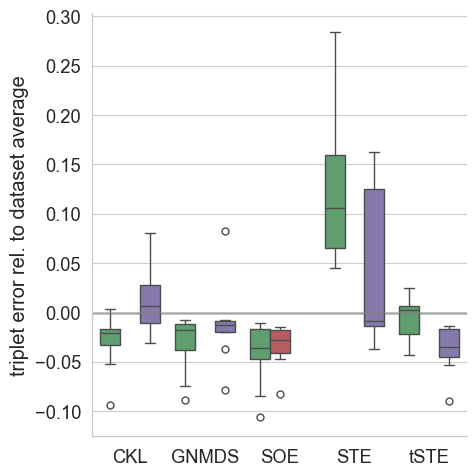

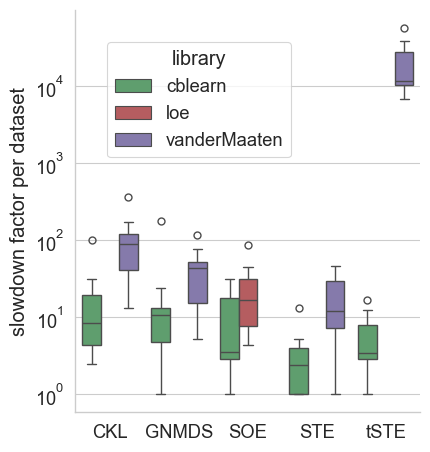

In [100]:
df = results[results.algorithm.isin(['SOE', 'STE', 'tSTE', 'CKL', 'GNMDS']) & ~results.is_gpu].copy(deep=True)
df = df.sort_values(by=['dataset', 'algorithm'])
colors = ['C2', 'C3', 'C4']
fg = plot_error_improvement(df, y='error', hue='library', palette=colors,
                            kind='box', hue_order=sorted(df.library.unique()), legend=False)
fg.savefig(plot_dir / f'deltaerror-per-algorithm_library.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_library.png')
plt.show()

fg = plot_time_improvement(df, y='cpu_time', hue='library', palette=colors,
                           kind='box', hue_order=sorted(df.library.unique()))
sns.move_legend(fg, 'upper left', frameon=True, bbox_to_anchor=(0.25, .91))
fg.set(yscale=('log'))
fg.savefig(plot_dir / f'deltatime-per-algorithm_library.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_library.png')

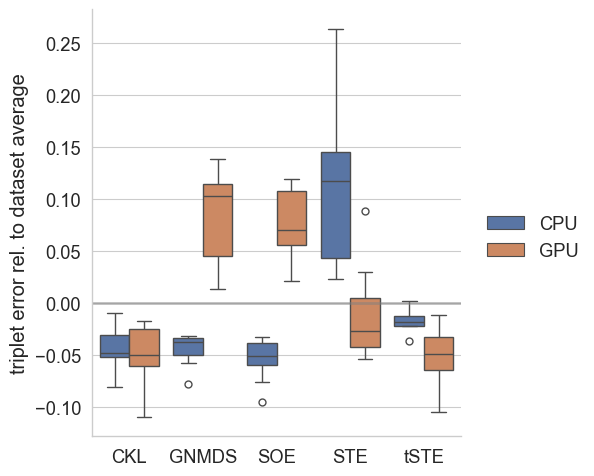

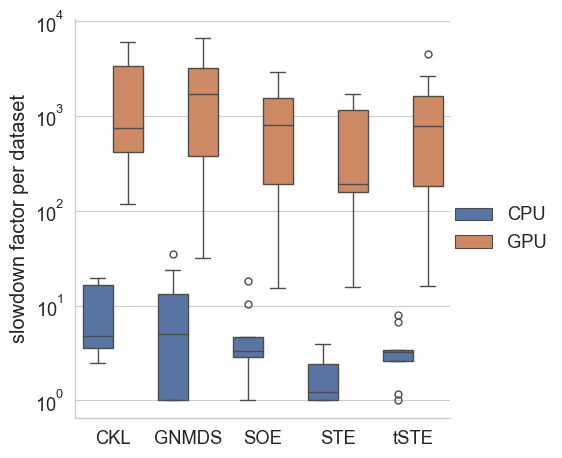

In [101]:
df = results[results.algorithm.isin(['SOE', 'SOE-GPU', 'STE', 'STE-GPU', 'tSTE', 'tSTE-GPU', 'CKL', 'CKL-GPU', 'GNMDS', 'GNMDS-GPU'])]
df = df[df.library == 'cblearn'].copy(deep=True).sort_values('algorithm')
fg = plot_error_improvement(df, y='error', hue='proc', hue_order=['CPU', 'GPU'], kind='box', groupby=['dataset'])
fg.legend.set_title('')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_gpu.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_gpu.png')
plt.show()

fg = plot_time_improvement(df, y='cpu_time', hue='proc', hue_order=['CPU', 'GPU'], kind='box', groupby=['dataset'])
fg.legend.set_title('')
fg.set(yscale=('log'))
fg.savefig(plot_dir / f'deltatime-per-algorithm_gpu.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_gpu.png')

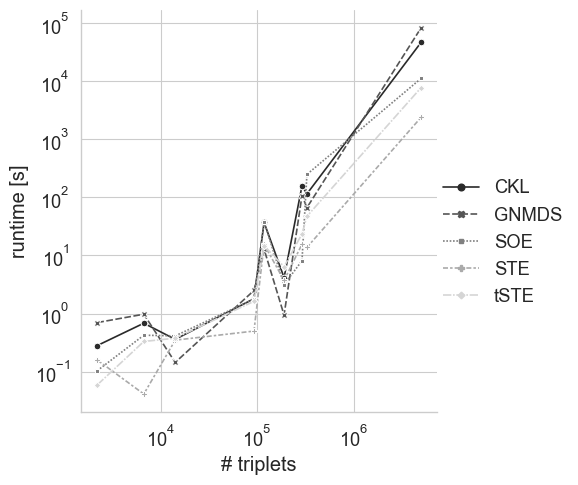

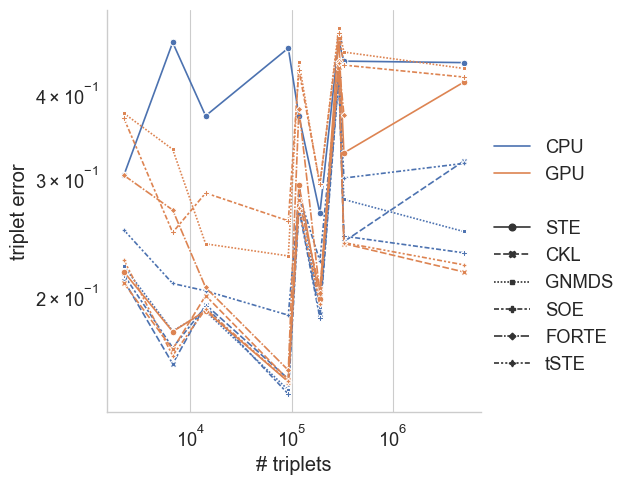

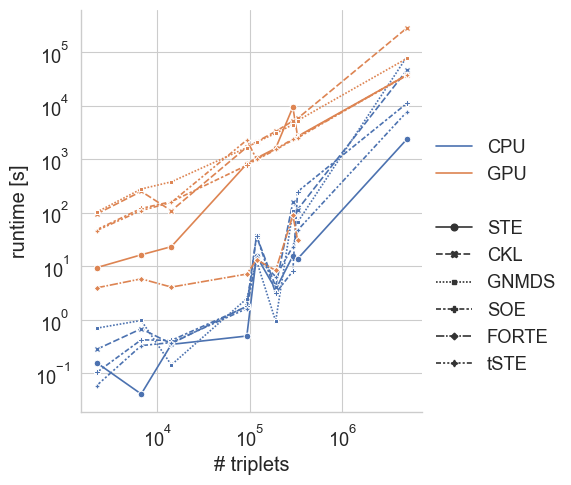

In [102]:
def plot_runtime(results, y='cpu_time', **kwargs):
    fg = sns.relplot(results, x='n_triplets', y=y, kind='line', dashes=True, markers=True, **kwargs)
    fg.set(xlabel='# triplets', ylabel='runtime [s]', xscale='log', yscale='log')
    return fg
#
def plot_error(results, y='error', **kwargs):
    fg = sns.relplot(results, x='n_triplets', y=y, kind='line', dashes=True, markers=True, **kwargs)
    fg.set(xlabel='# triplets', ylabel='triplet error', xscale='log', yscale='log')
    return fg


fg = plot_runtime(results.query('library == "cblearn" and not is_gpu'), hue='algorithm',
                  palette='grey', style='algorithm')
fg.legend.set_title("")
fg.savefig(plot_dir / f'time-per-triplets_cblearn.pdf')
fg.savefig(plot_dir / f'time-per-triplets_cblearn.png')

fg = plot_error(results.query('library == "cblearn"'), hue='proc',
                hue_order=['CPU', 'GPU'],
                style='algorithm')
fg.legend.texts[0].set_text('')
fg.legend.texts[3].set_text('')
fg.savefig(plot_dir / f'error-per-triplets_gpu.pdf')
fg.savefig(plot_dir / f'error-per-triplets_gpu.png')

fg = plot_runtime(results.query('library == "cblearn"'), hue='proc',
                  hue_order=['CPU', 'GPU'],
                  style='algorithm')
fg.legend.texts[0].set_text('')
fg.legend.texts[3].set_text('')
fg.savefig(plot_dir / f'time-per-triplets_gpu.pdf')
fg.savefig(plot_dir / f'time-per-triplets_gpu.png')